In [1]:
import numpy as np
import bilby 
import pycbc 
import sys
import matplotlib.pyplot as plt
import pandas as pd
from glasflow import RealNVP, CouplingNSF

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn

import pickle
import os
import json
import glob
import time

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
/home/qian.hu/.conda/envs/myigwn-py39/lib/python3.9/site-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(True)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal


In [2]:
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")

import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
#from .utils import PARAMETER_NAMES_ALL_PRECESSINGBNS_BILBY
from river.models.utils import *
from river.data.utils import *

import river.data
from river.data.datagenerator import DataGeneratorBilbyFD
from river.data.dataset import DatasetSVDStrainFDFromSVDWFonGPU, DatasetSVDStrainFDFromSVDWFonGPUBatch
from river.data.dataset import DatasetConvStrainFDFromSVDWFonGPU, DatasetConvStrainFDFromSVDWFonGPUBatch
#import river.data.utils as datautils
from river.data.utils import *
from river.data.reparameterize import *

from river.models import embedding
from river.models.utils import *
#from river.models.embedding.pca import project_strain_data_FDAPhi
from river.models.embedding.conv import EmbeddingConv1D, EmbeddingConv2D
from river.models.embedding.mlp import EmbeddingMLP1D
from river.models.inference.cnf import GlasflowEmbdding

In [3]:
source_type = 'BNS'
detector_names = ['H1', 'L1', 'V1'] 
duration = 32
f_low = 50
f_high = 1024

f_ref = 20
sampling_frequency = 2048
waveform_approximant = 'IMRPhenomPv2_NRTidal'
parameter_names = PARAMETER_NAMES_ALL_PRECESSINGBNS_BILBY
PSD_type = 'bilby_default' #'zero_noise' bilby_default
use_sealgw_detector = True

Vhfile="/home/qian.hu/mlpe/river/test/outputs/Vh_50Hz1024Hz32s.pickle"

data_generator = DataGeneratorBilbyFD(source_type,
            detector_names, 
            duration, 
            f_low, 
            f_ref, 
            sampling_frequency, 
            waveform_approximant, 
            parameter_names,
            PSD_type=PSD_type,
            use_sealgw_detector=use_sealgw_detector,
            f_high=f_high)

10:41 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_neutron_star
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


Using bilby_default PSDs to generate data.


In [4]:
validfolder = '/home/qian.hu/mlpe/training_data/bns_50Hz1024Hz32s_lowspin_lb/valid'
trainfolder = '/home/qian.hu/mlpe/training_data/bns_50Hz1024Hz32s_lowspin_lb/train'
#noisefolder = '/home/qian.hu/mlpe/training_data/bns_50Hz1024Hz32s_lowspin/noise/design'

valid_filenames = glob.glob(f"{validfolder}/batch*/*.h5")
train_filenames = glob.glob(f"{trainfolder}/batch*/*.h5")

add_noise = True
do_reparameterize = True
fix_extrinsic = False



In [7]:
len(train_filenames)

64

In [21]:
test_minibatch_sizes = [1,2,4,8,16,32,64,128]
batch_size = 4096

time_costs = []
for minibatch_size in test_minibatch_sizes:
    dataset_test = DatasetSVDStrainFDFromSVDWFonGPUBatch(train_filenames[:1], PARAMETER_NAMES_CONTEXT_PRECESSINGBNS_BILBY, data_generator,
                                                         Nbasis=512, Vhfile=Vhfile, fix_extrinsic=fix_extrinsic,
                                                         add_noise=add_noise,reparameterize=do_reparameterize,
                                                         minibatch_size = minibatch_size)
    dataloader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)
    
    t1 = time.time()
    for x,theta in dataloader:
        pass
    t2 = time.time()
    time_costs.append(t2-t1)
    


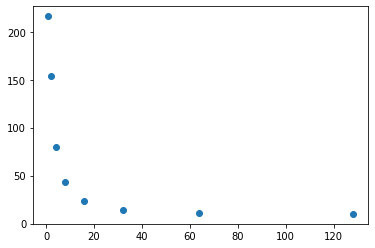

In [22]:
plt.scatter(test_minibatch_sizes, time_costs)
#plt.xscale('log')

In [23]:
time_costs

[216.23342609405518,
 154.24985337257385,
 79.40092945098877,
 43.03857898712158,
 23.77131724357605,
 13.594732522964478,
 11.231017827987671,
 10.010875463485718]

In [15]:
time_costs

[258.207382440567,
 154.33177518844604,
 79.56050205230713,
 45.694201707839966,
 24.71284770965576,
 13.604573965072632,
 12.243962287902832,
 10.730188369750977]